# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [41]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

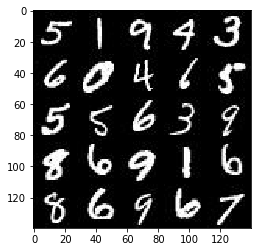

In [42]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline

import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

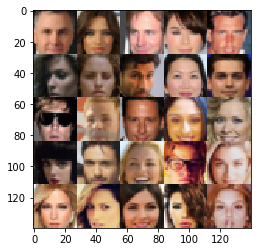

In [43]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [44]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [45]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_tensor = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="inputs")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return input_tensor, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [80]:
def discriminator(images, reuse=False, alpha=0.02):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, 
                              padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, 
                              padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, 
                              padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        # logits = tf.nn.dropout(logits, keep_prob=0.5)
        
        out = tf.sigmoid(logits)
        # out = tf.nn.dropout(out, keep_prob=0.5)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [81]:
def generator(z, out_channel_dim, is_train=True, alpha=0.02):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        # logits = tf.nn.dropout(logits, keep_prob=0.5)
        out = tf.tanh(logits)
        # out = tf.nn.dropout(out, keep_prob=0.5)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [75]:
def GANLoss(logits, is_real=True, smoothing=0.9, name=None):
    """
    Credit to:
    https://github.com/ilguyi/dcgan.tensorflow/blob/master/ops.py
    """
    if is_real:
    # one side label smoothing
        # labels = tf.fill(logits.get_shape(), smoothing)
        labels = tf.ones_like(logits)
        labels = labels - 0.1
    else:
        labels = tf.zeros_like(logits)

    with tf.name_scope(name, 'GAN_loss', [logits, labels]) as name:
        loss = tf.reduce_mean(
              tf.nn.sigmoid_cross_entropy_with_logits(
                              labels=labels,
                              logits=logits))
    return loss

def model_loss(input_real, input_z, out_channel_dim, alpha=0.02):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
        
    #d_loss_real = tf.reduce_mean(
    #    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    #d_loss_fake = tf.reduce_mean(
    #    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    #g_loss = tf.reduce_mean(
    #    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.fill(labels.get_shape(), 0.9)))

    d_loss_real = GANLoss(d_logits_real, is_real=True)
    d_loss_fake = GANLoss(d_logits_fake, is_real=False)
    g_loss = GANLoss(d_logits_fake, is_real=True)
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [76]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [77]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [78]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        # model_inputs(image_width, image_height, image_channels, z_dim)
        self.input_real, self.input_z, lr = model_inputs(real_size[1], real_size[2], real_size[3], z_size)
        # lr = learning_rate
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[3], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)
        
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    net = GAN(data_shape, z_dim, learning_rate, beta1=beta1) 
    
    show_every = 100
    print_every = 10
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for steps, batch_images in enumerate(get_batches(batch_size)):
                try:
                    batch_images=batch_images*2
                    # Sample random noise for G
                    batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                    # Run optimizers
                    _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                    _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})

                    if steps % print_every == 0:
                        # At the end of each epoch, get the losses and print them out
                        train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                        train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                        print("Step {} of Epoch {}/{}...".format(steps, epoch_i+1, epochs),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))

                    if steps % show_every == 0:
                        show_generator_output(sess, batch_size, net.input_z, data_shape[3], data_image_mode)
                except IndexError as e:
                    print('Might have ended')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 0 of Epoch 1/2... Discriminator Loss: 4.6473... Generator Loss: 0.4421


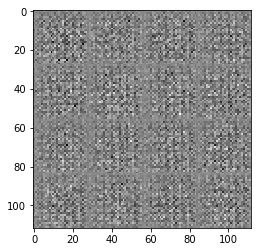

Step 10 of Epoch 1/2... Discriminator Loss: 0.9734... Generator Loss: 1.9960
Step 20 of Epoch 1/2... Discriminator Loss: 1.0875... Generator Loss: 2.3397
Step 30 of Epoch 1/2... Discriminator Loss: 1.1427... Generator Loss: 0.7200
Step 40 of Epoch 1/2... Discriminator Loss: 0.6944... Generator Loss: 1.4892
Step 50 of Epoch 1/2... Discriminator Loss: 0.4740... Generator Loss: 2.1098
Step 60 of Epoch 1/2... Discriminator Loss: 0.4634... Generator Loss: 2.0377
Step 70 of Epoch 1/2... Discriminator Loss: 0.8627... Generator Loss: 0.9863
Step 80 of Epoch 1/2... Discriminator Loss: 0.8111... Generator Loss: 6.7706
Step 90 of Epoch 1/2... Discriminator Loss: 0.4590... Generator Loss: 2.1327
Step 100 of Epoch 1/2... Discriminator Loss: 0.4238... Generator Loss: 2.5797


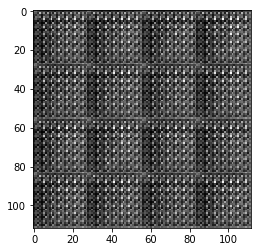

Step 110 of Epoch 1/2... Discriminator Loss: 0.4834... Generator Loss: 3.1817
Step 120 of Epoch 1/2... Discriminator Loss: 0.9841... Generator Loss: 1.0943
Step 130 of Epoch 1/2... Discriminator Loss: 1.1667... Generator Loss: 0.8670
Step 140 of Epoch 1/2... Discriminator Loss: 2.9063... Generator Loss: 0.3522
Step 150 of Epoch 1/2... Discriminator Loss: 1.1687... Generator Loss: 0.9943
Step 160 of Epoch 1/2... Discriminator Loss: 1.0985... Generator Loss: 1.0231
Step 170 of Epoch 1/2... Discriminator Loss: 0.8779... Generator Loss: 1.6404
Step 180 of Epoch 1/2... Discriminator Loss: 1.3254... Generator Loss: 0.6582
Step 190 of Epoch 1/2... Discriminator Loss: 1.1128... Generator Loss: 0.9369
Step 200 of Epoch 1/2... Discriminator Loss: 1.2725... Generator Loss: 0.6729


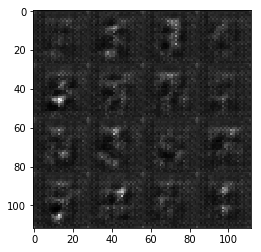

Step 210 of Epoch 1/2... Discriminator Loss: 1.6825... Generator Loss: 0.5316
Step 220 of Epoch 1/2... Discriminator Loss: 1.3747... Generator Loss: 0.6539
Step 230 of Epoch 1/2... Discriminator Loss: 1.6098... Generator Loss: 0.5316
Step 240 of Epoch 1/2... Discriminator Loss: 1.0592... Generator Loss: 1.2032
Step 250 of Epoch 1/2... Discriminator Loss: 1.8514... Generator Loss: 0.4301
Step 260 of Epoch 1/2... Discriminator Loss: 1.2582... Generator Loss: 0.6494
Step 270 of Epoch 1/2... Discriminator Loss: 1.2429... Generator Loss: 0.6788
Step 280 of Epoch 1/2... Discriminator Loss: 1.1401... Generator Loss: 0.7035
Step 290 of Epoch 1/2... Discriminator Loss: 1.5145... Generator Loss: 0.6193
Step 300 of Epoch 1/2... Discriminator Loss: 1.5462... Generator Loss: 0.6021


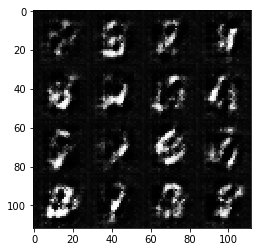

Step 310 of Epoch 1/2... Discriminator Loss: 0.9838... Generator Loss: 0.9938
Step 320 of Epoch 1/2... Discriminator Loss: 1.3293... Generator Loss: 0.9414
Step 330 of Epoch 1/2... Discriminator Loss: 1.4231... Generator Loss: 0.5984
Step 340 of Epoch 1/2... Discriminator Loss: 1.1937... Generator Loss: 0.8703
Step 350 of Epoch 1/2... Discriminator Loss: 1.5577... Generator Loss: 0.5674
Step 360 of Epoch 1/2... Discriminator Loss: 1.2767... Generator Loss: 0.9279
Step 370 of Epoch 1/2... Discriminator Loss: 1.2082... Generator Loss: 0.6725
Step 380 of Epoch 1/2... Discriminator Loss: 1.1489... Generator Loss: 0.7594
Step 390 of Epoch 1/2... Discriminator Loss: 1.7941... Generator Loss: 0.4584
Step 400 of Epoch 1/2... Discriminator Loss: 1.2518... Generator Loss: 0.6987


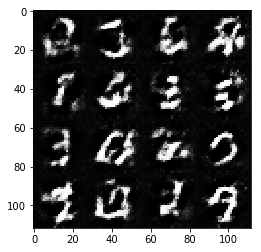

Step 410 of Epoch 1/2... Discriminator Loss: 1.5626... Generator Loss: 0.5280
Step 420 of Epoch 1/2... Discriminator Loss: 0.9659... Generator Loss: 1.0614
Step 430 of Epoch 1/2... Discriminator Loss: 1.0287... Generator Loss: 0.8756
Step 440 of Epoch 1/2... Discriminator Loss: 1.4720... Generator Loss: 0.5950
Step 450 of Epoch 1/2... Discriminator Loss: 1.3049... Generator Loss: 0.7377
Step 460 of Epoch 1/2... Discriminator Loss: 1.3362... Generator Loss: 0.6487
Step 470 of Epoch 1/2... Discriminator Loss: 1.1747... Generator Loss: 0.9696
Step 480 of Epoch 1/2... Discriminator Loss: 1.0837... Generator Loss: 0.7882
Step 490 of Epoch 1/2... Discriminator Loss: 1.3669... Generator Loss: 0.5817
Step 500 of Epoch 1/2... Discriminator Loss: 1.0820... Generator Loss: 1.0831


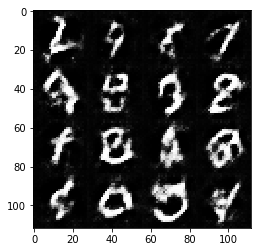

Step 510 of Epoch 1/2... Discriminator Loss: 1.1447... Generator Loss: 0.8493
Step 520 of Epoch 1/2... Discriminator Loss: 1.4516... Generator Loss: 0.5376
Step 530 of Epoch 1/2... Discriminator Loss: 1.1308... Generator Loss: 0.8699
Step 540 of Epoch 1/2... Discriminator Loss: 1.1769... Generator Loss: 0.7391
Step 550 of Epoch 1/2... Discriminator Loss: 0.9575... Generator Loss: 1.1847
Step 560 of Epoch 1/2... Discriminator Loss: 1.0947... Generator Loss: 1.0242
Step 570 of Epoch 1/2... Discriminator Loss: 1.0315... Generator Loss: 1.2710
Step 580 of Epoch 1/2... Discriminator Loss: 1.0705... Generator Loss: 0.9047
Step 590 of Epoch 1/2... Discriminator Loss: 1.3140... Generator Loss: 0.7029
Step 600 of Epoch 1/2... Discriminator Loss: 1.3824... Generator Loss: 0.5407


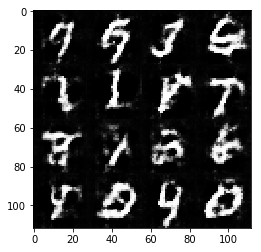

Step 610 of Epoch 1/2... Discriminator Loss: 1.8857... Generator Loss: 0.3917
Step 620 of Epoch 1/2... Discriminator Loss: 1.2994... Generator Loss: 0.7460
Step 630 of Epoch 1/2... Discriminator Loss: 1.0152... Generator Loss: 1.0029
Step 640 of Epoch 1/2... Discriminator Loss: 1.1124... Generator Loss: 0.8079
Step 650 of Epoch 1/2... Discriminator Loss: 1.1150... Generator Loss: 0.8045
Step 660 of Epoch 1/2... Discriminator Loss: 1.3024... Generator Loss: 0.5538
Step 670 of Epoch 1/2... Discriminator Loss: 1.5938... Generator Loss: 0.5255
Step 680 of Epoch 1/2... Discriminator Loss: 1.2636... Generator Loss: 0.7322
Step 690 of Epoch 1/2... Discriminator Loss: 1.5873... Generator Loss: 0.4550
Step 700 of Epoch 1/2... Discriminator Loss: 1.2079... Generator Loss: 0.8035


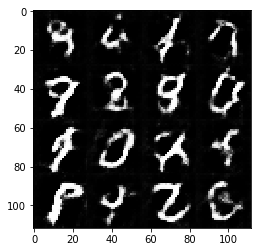

Step 710 of Epoch 1/2... Discriminator Loss: 1.2674... Generator Loss: 0.7803
Step 720 of Epoch 1/2... Discriminator Loss: 1.8552... Generator Loss: 0.4139
Step 730 of Epoch 1/2... Discriminator Loss: 1.1659... Generator Loss: 0.9096
Step 740 of Epoch 1/2... Discriminator Loss: 1.3192... Generator Loss: 0.5721
Step 750 of Epoch 1/2... Discriminator Loss: 0.9884... Generator Loss: 1.6177
Step 760 of Epoch 1/2... Discriminator Loss: 1.1167... Generator Loss: 1.3019
Step 770 of Epoch 1/2... Discriminator Loss: 1.1452... Generator Loss: 0.7320
Step 780 of Epoch 1/2... Discriminator Loss: 1.1537... Generator Loss: 0.6940
Step 790 of Epoch 1/2... Discriminator Loss: 0.9861... Generator Loss: 0.8657
Step 800 of Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 0.6275


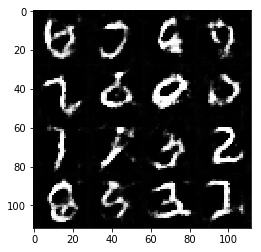

Step 810 of Epoch 1/2... Discriminator Loss: 1.3690... Generator Loss: 0.5358
Step 820 of Epoch 1/2... Discriminator Loss: 1.8509... Generator Loss: 0.3985
Step 830 of Epoch 1/2... Discriminator Loss: 1.3902... Generator Loss: 0.5547
Step 840 of Epoch 1/2... Discriminator Loss: 1.1259... Generator Loss: 0.9089
Step 850 of Epoch 1/2... Discriminator Loss: 1.0895... Generator Loss: 1.2053
Step 860 of Epoch 1/2... Discriminator Loss: 1.5176... Generator Loss: 0.4904
Step 870 of Epoch 1/2... Discriminator Loss: 1.0306... Generator Loss: 0.9026
Step 880 of Epoch 1/2... Discriminator Loss: 1.2170... Generator Loss: 0.8650
Step 890 of Epoch 1/2... Discriminator Loss: 1.2958... Generator Loss: 0.5908
Step 900 of Epoch 1/2... Discriminator Loss: 0.9206... Generator Loss: 1.3539


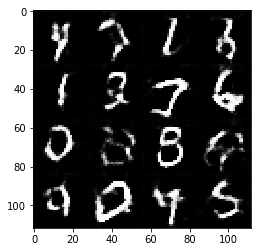

Step 910 of Epoch 1/2... Discriminator Loss: 1.0396... Generator Loss: 0.9120
Step 920 of Epoch 1/2... Discriminator Loss: 1.1993... Generator Loss: 0.7768
Step 930 of Epoch 1/2... Discriminator Loss: 1.1354... Generator Loss: 0.7031
Step 940 of Epoch 1/2... Discriminator Loss: 1.0007... Generator Loss: 0.8358
Step 950 of Epoch 1/2... Discriminator Loss: 1.0448... Generator Loss: 0.8312
Step 960 of Epoch 1/2... Discriminator Loss: 0.7681... Generator Loss: 1.1920
Step 970 of Epoch 1/2... Discriminator Loss: 0.8985... Generator Loss: 1.2082
Step 980 of Epoch 1/2... Discriminator Loss: 1.4126... Generator Loss: 0.5645
Step 990 of Epoch 1/2... Discriminator Loss: 0.9023... Generator Loss: 1.7421
Step 1000 of Epoch 1/2... Discriminator Loss: 1.0601... Generator Loss: 0.9631


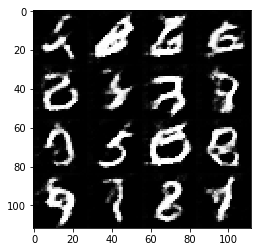

Step 1010 of Epoch 1/2... Discriminator Loss: 1.1871... Generator Loss: 0.7084
Step 1020 of Epoch 1/2... Discriminator Loss: 1.1481... Generator Loss: 0.8497
Step 1030 of Epoch 1/2... Discriminator Loss: 1.0004... Generator Loss: 0.9077
Step 1040 of Epoch 1/2... Discriminator Loss: 1.0463... Generator Loss: 0.7949
Step 1050 of Epoch 1/2... Discriminator Loss: 1.2362... Generator Loss: 0.7619
Step 1060 of Epoch 1/2... Discriminator Loss: 1.3729... Generator Loss: 0.5501
Step 1070 of Epoch 1/2... Discriminator Loss: 1.0220... Generator Loss: 0.9511
Step 1080 of Epoch 1/2... Discriminator Loss: 1.2696... Generator Loss: 0.6048
Step 1090 of Epoch 1/2... Discriminator Loss: 1.0543... Generator Loss: 0.9370
Step 1100 of Epoch 1/2... Discriminator Loss: 1.0557... Generator Loss: 0.7722


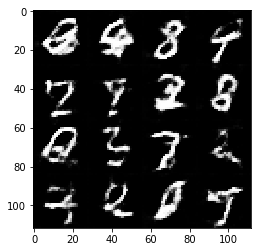

Step 1110 of Epoch 1/2... Discriminator Loss: 1.3483... Generator Loss: 0.6222
Step 1120 of Epoch 1/2... Discriminator Loss: 0.9074... Generator Loss: 1.1402
Step 1130 of Epoch 1/2... Discriminator Loss: 1.1940... Generator Loss: 0.7094
Step 1140 of Epoch 1/2... Discriminator Loss: 1.1364... Generator Loss: 1.7813
Step 1150 of Epoch 1/2... Discriminator Loss: 1.2391... Generator Loss: 0.6551
Step 1160 of Epoch 1/2... Discriminator Loss: 1.2615... Generator Loss: 0.6504
Step 1170 of Epoch 1/2... Discriminator Loss: 0.7497... Generator Loss: 1.2633
Step 1180 of Epoch 1/2... Discriminator Loss: 1.3418... Generator Loss: 0.5919
Step 1190 of Epoch 1/2... Discriminator Loss: 1.0479... Generator Loss: 0.8529
Step 1200 of Epoch 1/2... Discriminator Loss: 1.6304... Generator Loss: 0.5150


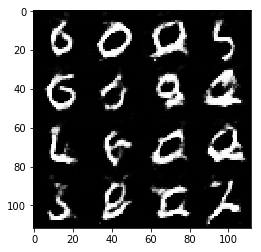

Step 1210 of Epoch 1/2... Discriminator Loss: 1.1355... Generator Loss: 0.8020
Step 1220 of Epoch 1/2... Discriminator Loss: 2.1223... Generator Loss: 0.3885
Step 1230 of Epoch 1/2... Discriminator Loss: 1.0937... Generator Loss: 0.8121
Step 1240 of Epoch 1/2... Discriminator Loss: 1.1433... Generator Loss: 0.7244
Step 1250 of Epoch 1/2... Discriminator Loss: 1.3486... Generator Loss: 0.5417
Step 1260 of Epoch 1/2... Discriminator Loss: 1.2210... Generator Loss: 0.6576
Step 1270 of Epoch 1/2... Discriminator Loss: 1.2687... Generator Loss: 0.6149
Step 1280 of Epoch 1/2... Discriminator Loss: 0.8969... Generator Loss: 1.0507
Step 1290 of Epoch 1/2... Discriminator Loss: 0.7075... Generator Loss: 1.3726
Step 1300 of Epoch 1/2... Discriminator Loss: 1.3452... Generator Loss: 0.5814


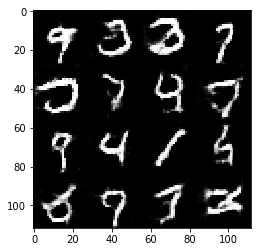

Step 1310 of Epoch 1/2... Discriminator Loss: 0.8890... Generator Loss: 1.0558
Step 1320 of Epoch 1/2... Discriminator Loss: 1.3557... Generator Loss: 0.6482
Step 1330 of Epoch 1/2... Discriminator Loss: 1.1662... Generator Loss: 0.6743
Step 1340 of Epoch 1/2... Discriminator Loss: 0.9089... Generator Loss: 0.9195
Step 1350 of Epoch 1/2... Discriminator Loss: 1.3061... Generator Loss: 0.6007
Step 1360 of Epoch 1/2... Discriminator Loss: 0.9755... Generator Loss: 1.4773
Step 1370 of Epoch 1/2... Discriminator Loss: 1.0422... Generator Loss: 0.9316
Step 1380 of Epoch 1/2... Discriminator Loss: 1.0712... Generator Loss: 0.9208
Step 1390 of Epoch 1/2... Discriminator Loss: 0.8963... Generator Loss: 0.9419
Step 1400 of Epoch 1/2... Discriminator Loss: 1.5901... Generator Loss: 0.4908


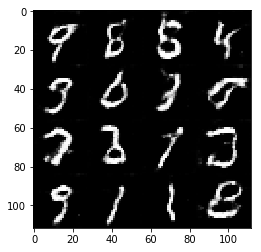

Step 1410 of Epoch 1/2... Discriminator Loss: 1.0714... Generator Loss: 0.9026
Step 1420 of Epoch 1/2... Discriminator Loss: 0.9534... Generator Loss: 0.9194
Step 1430 of Epoch 1/2... Discriminator Loss: 0.8569... Generator Loss: 1.8299
Step 1440 of Epoch 1/2... Discriminator Loss: 1.0171... Generator Loss: 0.8090
Step 1450 of Epoch 1/2... Discriminator Loss: 0.8965... Generator Loss: 0.9888
Step 1460 of Epoch 1/2... Discriminator Loss: 0.8517... Generator Loss: 1.2788
Step 1470 of Epoch 1/2... Discriminator Loss: 0.8778... Generator Loss: 1.3924
Step 1480 of Epoch 1/2... Discriminator Loss: 0.7195... Generator Loss: 1.2480
Step 1490 of Epoch 1/2... Discriminator Loss: 0.9329... Generator Loss: 1.8135
Step 1500 of Epoch 1/2... Discriminator Loss: 0.8174... Generator Loss: 1.6170


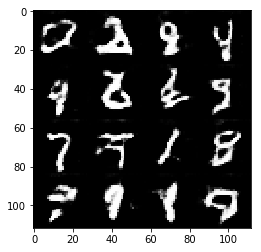

Step 1510 of Epoch 1/2... Discriminator Loss: 0.5947... Generator Loss: 1.6380
Step 1520 of Epoch 1/2... Discriminator Loss: 0.7761... Generator Loss: 1.0909
Step 1530 of Epoch 1/2... Discriminator Loss: 1.0841... Generator Loss: 0.8688
Step 1540 of Epoch 1/2... Discriminator Loss: 0.9684... Generator Loss: 0.8518
Step 1550 of Epoch 1/2... Discriminator Loss: 0.7688... Generator Loss: 1.1896
Step 1560 of Epoch 1/2... Discriminator Loss: 1.4616... Generator Loss: 0.5871
Step 1570 of Epoch 1/2... Discriminator Loss: 1.3021... Generator Loss: 0.6156
Step 1580 of Epoch 1/2... Discriminator Loss: 1.0341... Generator Loss: 0.8150
Step 1590 of Epoch 1/2... Discriminator Loss: 2.0051... Generator Loss: 0.4214
Step 1600 of Epoch 1/2... Discriminator Loss: 0.8091... Generator Loss: 1.1838


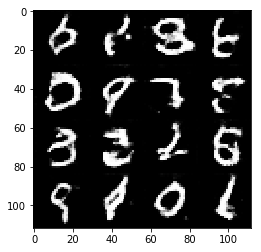

Step 1610 of Epoch 1/2... Discriminator Loss: 1.2420... Generator Loss: 0.8514
Step 1620 of Epoch 1/2... Discriminator Loss: 1.2640... Generator Loss: 0.6054
Step 1630 of Epoch 1/2... Discriminator Loss: 1.2210... Generator Loss: 0.7206
Step 1640 of Epoch 1/2... Discriminator Loss: 0.8054... Generator Loss: 1.3724
Step 1650 of Epoch 1/2... Discriminator Loss: 0.9805... Generator Loss: 1.0524
Step 1660 of Epoch 1/2... Discriminator Loss: 0.8890... Generator Loss: 1.0162
Step 1670 of Epoch 1/2... Discriminator Loss: 1.0897... Generator Loss: 0.8453
Step 1680 of Epoch 1/2... Discriminator Loss: 0.8494... Generator Loss: 1.1016
Step 1690 of Epoch 1/2... Discriminator Loss: 0.7290... Generator Loss: 1.6849
Step 1700 of Epoch 1/2... Discriminator Loss: 0.7173... Generator Loss: 1.4718


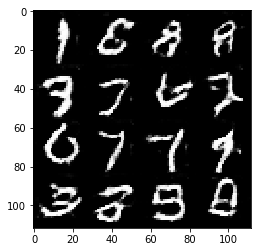

Step 1710 of Epoch 1/2... Discriminator Loss: 1.2921... Generator Loss: 0.6349
Step 1720 of Epoch 1/2... Discriminator Loss: 1.0943... Generator Loss: 0.8867
Step 1730 of Epoch 1/2... Discriminator Loss: 0.8571... Generator Loss: 2.1538
Step 1740 of Epoch 1/2... Discriminator Loss: 0.8795... Generator Loss: 0.9410
Step 1750 of Epoch 1/2... Discriminator Loss: 1.4162... Generator Loss: 0.5499
Step 1760 of Epoch 1/2... Discriminator Loss: 1.6237... Generator Loss: 0.4610
Step 1770 of Epoch 1/2... Discriminator Loss: 1.1534... Generator Loss: 0.6990
Step 1780 of Epoch 1/2... Discriminator Loss: 0.6444... Generator Loss: 1.9943
Step 1790 of Epoch 1/2... Discriminator Loss: 0.7495... Generator Loss: 1.4152
Step 1800 of Epoch 1/2... Discriminator Loss: 0.9535... Generator Loss: 0.8691


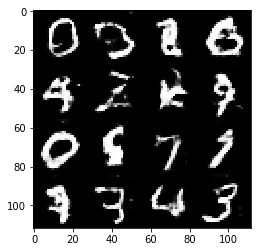

Step 1810 of Epoch 1/2... Discriminator Loss: 1.0297... Generator Loss: 0.7918
Step 1820 of Epoch 1/2... Discriminator Loss: 0.9064... Generator Loss: 2.1161
Step 1830 of Epoch 1/2... Discriminator Loss: 1.1658... Generator Loss: 0.7552
Step 1840 of Epoch 1/2... Discriminator Loss: 0.9547... Generator Loss: 0.9007
Step 1850 of Epoch 1/2... Discriminator Loss: 0.9889... Generator Loss: 0.9290
Step 1860 of Epoch 1/2... Discriminator Loss: 0.9081... Generator Loss: 0.8949
Step 1870 of Epoch 1/2... Discriminator Loss: 1.1802... Generator Loss: 0.6937
Step 1880 of Epoch 1/2... Discriminator Loss: 0.7733... Generator Loss: 1.1570
Step 1890 of Epoch 1/2... Discriminator Loss: 0.9683... Generator Loss: 0.9125
Step 1900 of Epoch 1/2... Discriminator Loss: 0.6800... Generator Loss: 1.3806


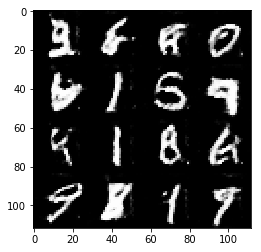

Step 1910 of Epoch 1/2... Discriminator Loss: 0.8761... Generator Loss: 0.9901
Step 1920 of Epoch 1/2... Discriminator Loss: 1.2917... Generator Loss: 0.7175
Step 1930 of Epoch 1/2... Discriminator Loss: 1.1151... Generator Loss: 0.8900
Step 1940 of Epoch 1/2... Discriminator Loss: 0.8821... Generator Loss: 1.0529
Step 1950 of Epoch 1/2... Discriminator Loss: 1.1298... Generator Loss: 1.1585
Step 1960 of Epoch 1/2... Discriminator Loss: 0.9668... Generator Loss: 0.8987
Step 1970 of Epoch 1/2... Discriminator Loss: 0.8719... Generator Loss: 1.1295
Step 1980 of Epoch 1/2... Discriminator Loss: 0.6756... Generator Loss: 1.4559
Step 1990 of Epoch 1/2... Discriminator Loss: 1.0741... Generator Loss: 0.7544
Step 2000 of Epoch 1/2... Discriminator Loss: 0.7925... Generator Loss: 1.8375


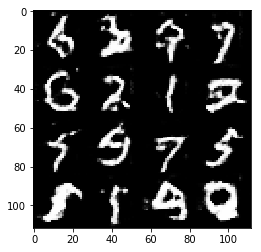

Step 2010 of Epoch 1/2... Discriminator Loss: 0.6055... Generator Loss: 1.5895
Step 2020 of Epoch 1/2... Discriminator Loss: 0.9065... Generator Loss: 1.3373
Step 2030 of Epoch 1/2... Discriminator Loss: 0.9414... Generator Loss: 0.9224
Step 2040 of Epoch 1/2... Discriminator Loss: 1.3682... Generator Loss: 1.9095
Step 2050 of Epoch 1/2... Discriminator Loss: 0.9896... Generator Loss: 1.0306
Step 2060 of Epoch 1/2... Discriminator Loss: 0.7746... Generator Loss: 1.2994
Step 2070 of Epoch 1/2... Discriminator Loss: 0.9018... Generator Loss: 1.0233
Step 2080 of Epoch 1/2... Discriminator Loss: 0.6927... Generator Loss: 1.3513
Step 2090 of Epoch 1/2... Discriminator Loss: 0.9068... Generator Loss: 1.1095
Step 2100 of Epoch 1/2... Discriminator Loss: 0.7570... Generator Loss: 1.2565


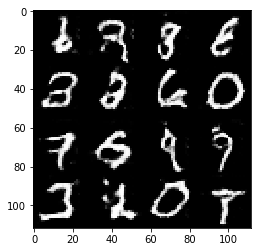

Step 2110 of Epoch 1/2... Discriminator Loss: 0.9128... Generator Loss: 0.9641
Step 2120 of Epoch 1/2... Discriminator Loss: 1.5121... Generator Loss: 0.5938
Step 2130 of Epoch 1/2... Discriminator Loss: 0.8567... Generator Loss: 1.1772
Step 2140 of Epoch 1/2... Discriminator Loss: 0.9549... Generator Loss: 0.9313
Step 2150 of Epoch 1/2... Discriminator Loss: 0.7050... Generator Loss: 1.3106
Step 2160 of Epoch 1/2... Discriminator Loss: 0.7344... Generator Loss: 1.2480
Step 2170 of Epoch 1/2... Discriminator Loss: 1.2306... Generator Loss: 0.8023
Step 2180 of Epoch 1/2... Discriminator Loss: 1.0948... Generator Loss: 0.8575
Step 2190 of Epoch 1/2... Discriminator Loss: 1.0097... Generator Loss: 0.8737
Step 2200 of Epoch 1/2... Discriminator Loss: 0.8269... Generator Loss: 1.0116


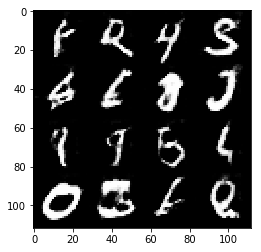

Step 2210 of Epoch 1/2... Discriminator Loss: 0.8497... Generator Loss: 1.1628
Step 2220 of Epoch 1/2... Discriminator Loss: 0.8486... Generator Loss: 1.1931
Step 2230 of Epoch 1/2... Discriminator Loss: 0.8170... Generator Loss: 1.3835
Step 2240 of Epoch 1/2... Discriminator Loss: 0.9505... Generator Loss: 0.8863
Step 2250 of Epoch 1/2... Discriminator Loss: 1.0117... Generator Loss: 1.8531
Step 2260 of Epoch 1/2... Discriminator Loss: 0.7258... Generator Loss: 1.2474
Step 2270 of Epoch 1/2... Discriminator Loss: 0.6966... Generator Loss: 1.4039
Step 2280 of Epoch 1/2... Discriminator Loss: 0.8305... Generator Loss: 1.8113
Step 2290 of Epoch 1/2... Discriminator Loss: 0.7460... Generator Loss: 1.2988
Step 2300 of Epoch 1/2... Discriminator Loss: 1.2845... Generator Loss: 0.6630


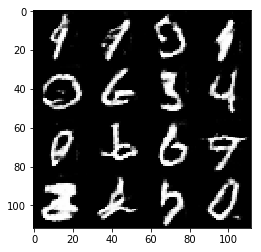

Step 2310 of Epoch 1/2... Discriminator Loss: 1.6446... Generator Loss: 0.4703
Step 2320 of Epoch 1/2... Discriminator Loss: 0.9689... Generator Loss: 0.9127
Step 2330 of Epoch 1/2... Discriminator Loss: 1.6732... Generator Loss: 0.4753
Step 2340 of Epoch 1/2... Discriminator Loss: 1.3210... Generator Loss: 0.6371
Step 2350 of Epoch 1/2... Discriminator Loss: 1.4531... Generator Loss: 0.6000
Step 2360 of Epoch 1/2... Discriminator Loss: 0.7197... Generator Loss: 1.5931
Step 2370 of Epoch 1/2... Discriminator Loss: 1.4666... Generator Loss: 0.6592
Step 2380 of Epoch 1/2... Discriminator Loss: 1.0138... Generator Loss: 0.8664
Step 2390 of Epoch 1/2... Discriminator Loss: 0.6682... Generator Loss: 1.3900
Step 2400 of Epoch 1/2... Discriminator Loss: 0.7750... Generator Loss: 1.4738


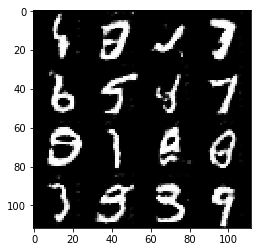

Step 2410 of Epoch 1/2... Discriminator Loss: 0.8547... Generator Loss: 1.0777
Step 2420 of Epoch 1/2... Discriminator Loss: 0.6341... Generator Loss: 1.4662
Step 2430 of Epoch 1/2... Discriminator Loss: 0.8781... Generator Loss: 0.9489
Step 2440 of Epoch 1/2... Discriminator Loss: 1.2099... Generator Loss: 0.6561
Step 2450 of Epoch 1/2... Discriminator Loss: 1.5535... Generator Loss: 0.7229
Step 2460 of Epoch 1/2... Discriminator Loss: 1.1297... Generator Loss: 0.9302
Step 2470 of Epoch 1/2... Discriminator Loss: 0.8955... Generator Loss: 0.9287
Step 2480 of Epoch 1/2... Discriminator Loss: 1.0446... Generator Loss: 0.8530
Step 2490 of Epoch 1/2... Discriminator Loss: 1.5763... Generator Loss: 0.5201
Step 2500 of Epoch 1/2... Discriminator Loss: 0.7470... Generator Loss: 1.1249


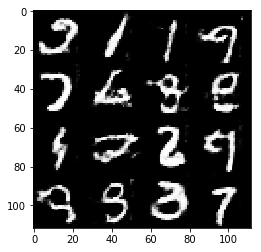

Step 2510 of Epoch 1/2... Discriminator Loss: 0.7556... Generator Loss: 1.0683
Step 2520 of Epoch 1/2... Discriminator Loss: 0.6802... Generator Loss: 1.7779
Step 2530 of Epoch 1/2... Discriminator Loss: 0.6862... Generator Loss: 1.3933
Step 2540 of Epoch 1/2... Discriminator Loss: 1.0223... Generator Loss: 0.9000
Step 2550 of Epoch 1/2... Discriminator Loss: 1.2104... Generator Loss: 0.8064
Step 2560 of Epoch 1/2... Discriminator Loss: 0.8699... Generator Loss: 1.0715
Step 2570 of Epoch 1/2... Discriminator Loss: 0.5842... Generator Loss: 1.5819
Step 2580 of Epoch 1/2... Discriminator Loss: 0.7070... Generator Loss: 1.4106
Step 2590 of Epoch 1/2... Discriminator Loss: 0.7195... Generator Loss: 1.2729
Step 2600 of Epoch 1/2... Discriminator Loss: 1.0969... Generator Loss: 0.7914


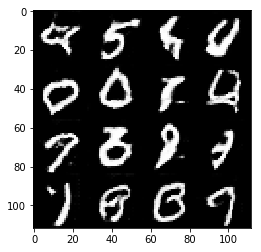

Step 2610 of Epoch 1/2... Discriminator Loss: 0.9595... Generator Loss: 0.9839
Step 2620 of Epoch 1/2... Discriminator Loss: 0.7436... Generator Loss: 1.1583
Step 2630 of Epoch 1/2... Discriminator Loss: 0.6294... Generator Loss: 1.6050
Step 2640 of Epoch 1/2... Discriminator Loss: 0.7141... Generator Loss: 1.3282
Step 2650 of Epoch 1/2... Discriminator Loss: 0.6562... Generator Loss: 1.5561
Step 2660 of Epoch 1/2... Discriminator Loss: 0.6272... Generator Loss: 1.5878
Step 2670 of Epoch 1/2... Discriminator Loss: 0.9637... Generator Loss: 0.9295
Step 2680 of Epoch 1/2... Discriminator Loss: 0.8470... Generator Loss: 1.0460
Step 2690 of Epoch 1/2... Discriminator Loss: 0.9319... Generator Loss: 0.9269
Step 2700 of Epoch 1/2... Discriminator Loss: 0.9777... Generator Loss: 0.8339


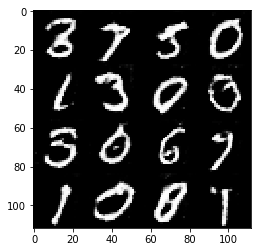

Step 2710 of Epoch 1/2... Discriminator Loss: 0.7995... Generator Loss: 1.0827
Step 2720 of Epoch 1/2... Discriminator Loss: 0.8511... Generator Loss: 1.0586


IndexError: list index out of range

In [82]:
batch_size = 16
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 0 of Epoch 1/1... Discriminator Loss: 8.1992... Generator Loss: 0.7779


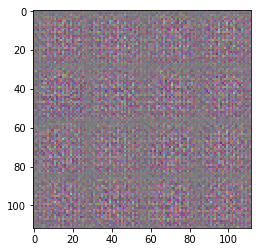

Step 10 of Epoch 1/1... Discriminator Loss: 3.6509... Generator Loss: 0.3743
Step 20 of Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 0.7564
Step 30 of Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.6464
Step 40 of Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 0.7142
Step 50 of Epoch 1/1... Discriminator Loss: 0.6123... Generator Loss: 1.4777
Step 60 of Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 5.6900
Step 70 of Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 1.0906
Step 80 of Epoch 1/1... Discriminator Loss: 2.5537... Generator Loss: 0.3353
Step 90 of Epoch 1/1... Discriminator Loss: 0.5141... Generator Loss: 2.7727
Step 100 of Epoch 1/1... Discriminator Loss: 0.4736... Generator Loss: 2.1983


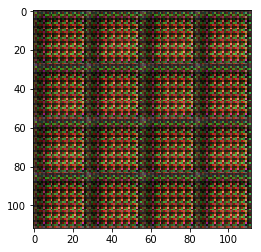

Step 110 of Epoch 1/1... Discriminator Loss: 0.4663... Generator Loss: 4.0809
Step 120 of Epoch 1/1... Discriminator Loss: 0.6245... Generator Loss: 1.7790
Step 130 of Epoch 1/1... Discriminator Loss: 0.5941... Generator Loss: 1.8874
Step 140 of Epoch 1/1... Discriminator Loss: 0.5914... Generator Loss: 1.7186
Step 150 of Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 0.8232
Step 160 of Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 0.9339
Step 170 of Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 0.8873
Step 180 of Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 0.9516
Step 190 of Epoch 1/1... Discriminator Loss: 0.8135... Generator Loss: 1.2387
Step 200 of Epoch 1/1... Discriminator Loss: 0.7210... Generator Loss: 1.5641


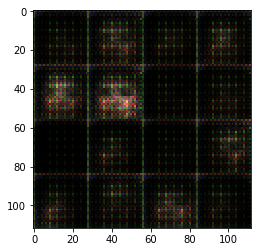

Step 210 of Epoch 1/1... Discriminator Loss: 0.6781... Generator Loss: 1.3367
Step 220 of Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 0.9581
Step 230 of Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.6197
Step 240 of Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 0.8958
Step 250 of Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 1.7183
Step 260 of Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 1.2146
Step 270 of Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7954
Step 280 of Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 1.0482
Step 290 of Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 1.8584
Step 300 of Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.7532


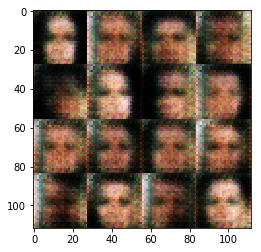

Step 310 of Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 1.6569
Step 320 of Epoch 1/1... Discriminator Loss: 0.8248... Generator Loss: 1.2128
Step 330 of Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.6490
Step 340 of Epoch 1/1... Discriminator Loss: 0.9522... Generator Loss: 1.1490
Step 350 of Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 0.9623
Step 360 of Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.8239
Step 370 of Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 1.0754
Step 380 of Epoch 1/1... Discriminator Loss: 0.8490... Generator Loss: 1.1987
Step 390 of Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 0.9911
Step 400 of Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 1.2071


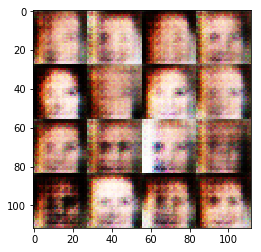

Step 410 of Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 1.8002
Step 420 of Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 1.2696
Step 430 of Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 1.1770
Step 440 of Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 1.1675
Step 450 of Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 1.0270
Step 460 of Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.7757
Step 470 of Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.6652
Step 480 of Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 0.9760
Step 490 of Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.7082
Step 500 of Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.7617


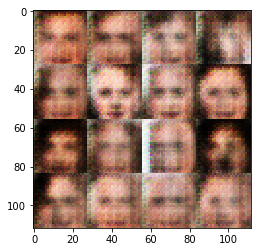

Step 510 of Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.8092
Step 520 of Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 1.6381
Step 530 of Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.7523
Step 540 of Epoch 1/1... Discriminator Loss: 1.5830... Generator Loss: 0.6405
Step 550 of Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.6323
Step 560 of Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.8199
Step 570 of Epoch 1/1... Discriminator Loss: 0.7983... Generator Loss: 1.3476
Step 580 of Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.7856
Step 590 of Epoch 1/1... Discriminator Loss: 2.1672... Generator Loss: 0.3860
Step 600 of Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 0.8575


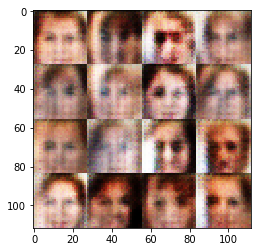

Step 610 of Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.6575
Step 620 of Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 0.9762
Step 630 of Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.6388
Step 640 of Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.8543
Step 650 of Epoch 1/1... Discriminator Loss: 1.5513... Generator Loss: 0.9393
Step 660 of Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.6030
Step 670 of Epoch 1/1... Discriminator Loss: 0.9113... Generator Loss: 1.1212
Step 680 of Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.9220
Step 690 of Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.5571
Step 700 of Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.9435


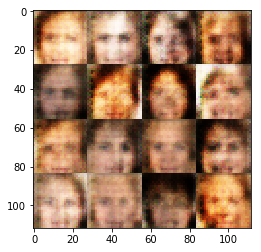

Step 710 of Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.7951
Step 720 of Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.7661
Step 730 of Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.7669
Step 740 of Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.6636
Step 750 of Epoch 1/1... Discriminator Loss: 1.6030... Generator Loss: 0.4592
Step 760 of Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 0.8917
Step 770 of Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 1.1123
Step 780 of Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 1.2087
Step 790 of Epoch 1/1... Discriminator Loss: 1.7679... Generator Loss: 0.4097
Step 800 of Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.5364


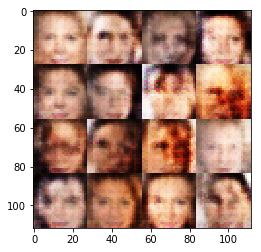

Step 810 of Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 0.6299
Step 820 of Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 0.9112
Step 830 of Epoch 1/1... Discriminator Loss: 2.0906... Generator Loss: 0.3788
Step 840 of Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.8252
Step 850 of Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.9180
Step 860 of Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 1.1047
Step 870 of Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.9425
Step 880 of Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.7958
Step 890 of Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.6405
Step 900 of Epoch 1/1... Discriminator Loss: 1.5407... Generator Loss: 0.5063


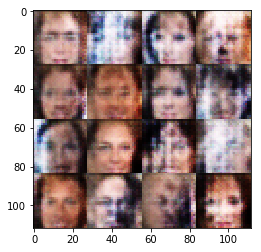

Step 910 of Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.5613
Step 920 of Epoch 1/1... Discriminator Loss: 1.5981... Generator Loss: 0.5491
Step 930 of Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 1.0558
Step 940 of Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.6199
Step 950 of Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.5987
Step 960 of Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 1.2601
Step 970 of Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 1.2741
Step 980 of Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.5733
Step 990 of Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 1.1069
Step 1000 of Epoch 1/1... Discriminator Loss: 1.8469... Generator Loss: 0.4168


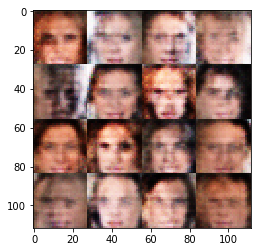

Step 1010 of Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.7565
Step 1020 of Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.5018
Step 1030 of Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.6134
Step 1040 of Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 0.7411
Step 1050 of Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.7801
Step 1060 of Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.9069
Step 1070 of Epoch 1/1... Discriminator Loss: 1.7082... Generator Loss: 0.4499
Step 1080 of Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 0.9877
Step 1090 of Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 1.2415
Step 1100 of Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.6220


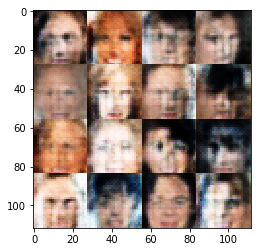

Step 1110 of Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.6423
Step 1120 of Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 0.8200
Step 1130 of Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.9664
Step 1140 of Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 1.1319
Step 1150 of Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.6810
Step 1160 of Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.7183
Step 1170 of Epoch 1/1... Discriminator Loss: 1.7034... Generator Loss: 0.5102
Step 1180 of Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.5705
Step 1190 of Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.5357
Step 1200 of Epoch 1/1... Discriminator Loss: 1.6033... Generator Loss: 0.5179


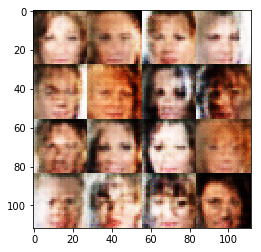

Step 1210 of Epoch 1/1... Discriminator Loss: 1.5611... Generator Loss: 0.4936
Step 1220 of Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.7086
Step 1230 of Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 1.0223
Step 1240 of Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.6773
Step 1250 of Epoch 1/1... Discriminator Loss: 0.9131... Generator Loss: 1.2202
Step 1260 of Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.9930
Step 1270 of Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 1.1125
Step 1280 of Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.4863
Step 1290 of Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.5860
Step 1300 of Epoch 1/1... Discriminator Loss: 1.5731... Generator Loss: 0.5838


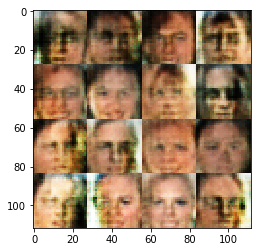

Step 1310 of Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.6553
Step 1320 of Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 0.9483
Step 1330 of Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.7556
Step 1340 of Epoch 1/1... Discriminator Loss: 1.6246... Generator Loss: 0.5088
Step 1350 of Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.5273
Step 1360 of Epoch 1/1... Discriminator Loss: 0.9016... Generator Loss: 1.0770
Step 1370 of Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 0.9616
Step 1380 of Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 1.0750
Step 1390 of Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.9019
Step 1400 of Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 0.9996


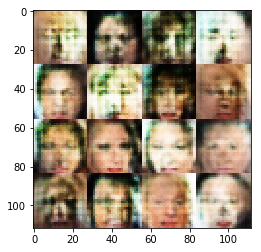

Step 1410 of Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 0.7902
Step 1420 of Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 0.8244
Step 1430 of Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 1.8352
Step 1440 of Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.7516
Step 1450 of Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 0.8595
Step 1460 of Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.7205
Step 1470 of Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.8990
Step 1480 of Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7173
Step 1490 of Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.6529
Step 1500 of Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.8696


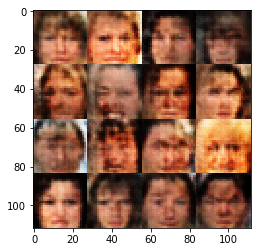

Step 1510 of Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.7817
Step 1520 of Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 0.7691
Step 1530 of Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.5551
Step 1540 of Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.6144
Step 1550 of Epoch 1/1... Discriminator Loss: 1.5247... Generator Loss: 0.4882
Step 1560 of Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.6016
Step 1570 of Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.6004
Step 1580 of Epoch 1/1... Discriminator Loss: 1.5458... Generator Loss: 0.5311
Step 1590 of Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.7020
Step 1600 of Epoch 1/1... Discriminator Loss: 1.6608... Generator Loss: 0.4691


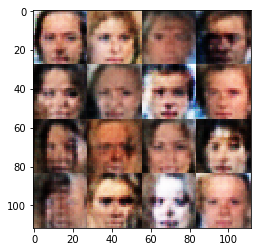

Step 1610 of Epoch 1/1... Discriminator Loss: 1.7485... Generator Loss: 0.4665
Step 1620 of Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 0.8400
Step 1630 of Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.6259
Step 1640 of Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 0.9841
Step 1650 of Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.5843
Step 1660 of Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.8210
Step 1670 of Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.5143
Step 1680 of Epoch 1/1... Discriminator Loss: 1.7584... Generator Loss: 0.4334
Step 1690 of Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.7310
Step 1700 of Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.8234


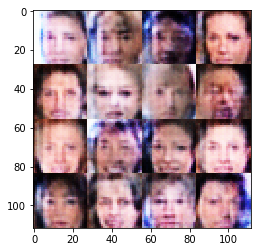

Step 1710 of Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.7211
Step 1720 of Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.5513
Step 1730 of Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.7297
Step 1740 of Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.9502
Step 1750 of Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.9431
Step 1760 of Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.8070
Step 1770 of Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.8401
Step 1780 of Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.8857
Step 1790 of Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.7318
Step 1800 of Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 1.1141


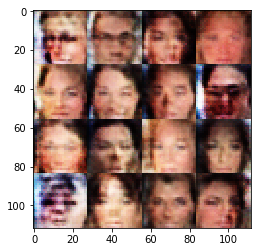

Step 1810 of Epoch 1/1... Discriminator Loss: 2.0214... Generator Loss: 0.4094
Step 1820 of Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.5773
Step 1830 of Epoch 1/1... Discriminator Loss: 0.8827... Generator Loss: 0.9265
Step 1840 of Epoch 1/1... Discriminator Loss: 1.6698... Generator Loss: 0.4346
Step 1850 of Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.9325
Step 1860 of Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.6244
Step 1870 of Epoch 1/1... Discriminator Loss: 1.6084... Generator Loss: 0.4968
Step 1880 of Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 1.1221
Step 1890 of Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.7128
Step 1900 of Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7277


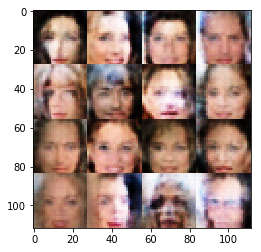

Step 1910 of Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.8968
Step 1920 of Epoch 1/1... Discriminator Loss: 0.8745... Generator Loss: 1.0145
Step 1930 of Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.9262
Step 1940 of Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 1.0399
Step 1950 of Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 0.8219
Step 1960 of Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.7651
Step 1970 of Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 1.0081
Step 1980 of Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.9953
Step 1990 of Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 0.9783
Step 2000 of Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.7081


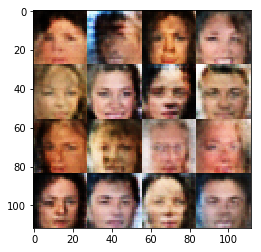

Step 2010 of Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.6919
Step 2020 of Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7385
Step 2030 of Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 1.0732
Step 2040 of Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.6711
Step 2050 of Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.5213
Step 2060 of Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.5650
Step 2070 of Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 0.9041
Step 2080 of Epoch 1/1... Discriminator Loss: 1.7345... Generator Loss: 0.4609
Step 2090 of Epoch 1/1... Discriminator Loss: 1.8367... Generator Loss: 0.4153
Step 2100 of Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.8826


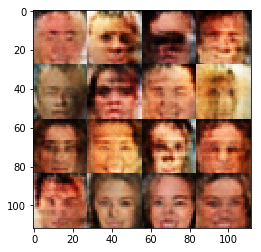

Step 2110 of Epoch 1/1... Discriminator Loss: 1.6753... Generator Loss: 0.5030
Step 2120 of Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.6853
Step 2130 of Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.8831
Step 2140 of Epoch 1/1... Discriminator Loss: 1.5976... Generator Loss: 0.4970
Step 2150 of Epoch 1/1... Discriminator Loss: 2.1501... Generator Loss: 0.3874
Step 2160 of Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 1.2111
Step 2170 of Epoch 1/1... Discriminator Loss: 1.6342... Generator Loss: 0.4581
Step 2180 of Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6019
Step 2190 of Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.7536
Step 2200 of Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.8007


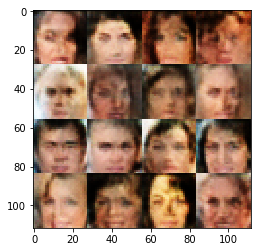

Step 2210 of Epoch 1/1... Discriminator Loss: 1.6299... Generator Loss: 0.5111
Step 2220 of Epoch 1/1... Discriminator Loss: 1.8393... Generator Loss: 0.3991
Step 2230 of Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.6102
Step 2240 of Epoch 1/1... Discriminator Loss: 1.7008... Generator Loss: 0.4337
Step 2250 of Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.6410
Step 2260 of Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.6731
Step 2270 of Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.6745
Step 2280 of Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.7528
Step 2290 of Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.7218
Step 2300 of Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 0.5268


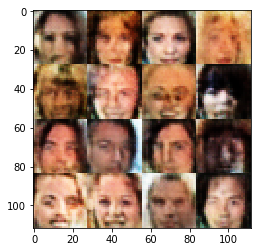

Step 2310 of Epoch 1/1... Discriminator Loss: 1.7863... Generator Loss: 0.4145
Step 2320 of Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.7804
Step 2330 of Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.6747
Step 2340 of Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.7912
Step 2350 of Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 1.0432
Step 2360 of Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.9915
Step 2370 of Epoch 1/1... Discriminator Loss: 2.2095... Generator Loss: 0.3950
Step 2380 of Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 0.8942
Step 2390 of Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.7740
Step 2400 of Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.8149


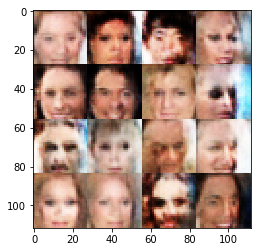

Step 2410 of Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.7106
Step 2420 of Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.8305
Step 2430 of Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.5467
Step 2440 of Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.6578
Step 2450 of Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 0.8313
Step 2460 of Epoch 1/1... Discriminator Loss: 0.9127... Generator Loss: 1.1477
Step 2470 of Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 1.1394
Step 2480 of Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.7238
Step 2490 of Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.6496
Step 2500 of Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 0.9803


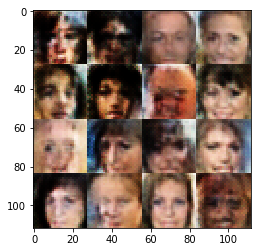

Step 2510 of Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.6527
Step 2520 of Epoch 1/1... Discriminator Loss: 1.5996... Generator Loss: 0.4528
Step 2530 of Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 1.1953
Step 2540 of Epoch 1/1... Discriminator Loss: 1.6364... Generator Loss: 0.4802
Step 2550 of Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 1.2857
Step 2560 of Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.9462
Step 2570 of Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.9043
Step 2580 of Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 1.0526
Step 2590 of Epoch 1/1... Discriminator Loss: 1.5561... Generator Loss: 0.4967
Step 2600 of Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.6031


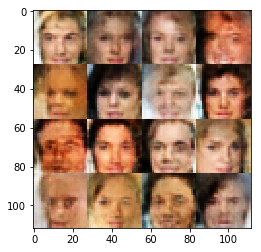

Step 2610 of Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.7492
Step 2620 of Epoch 1/1... Discriminator Loss: 1.6179... Generator Loss: 0.4850
Step 2630 of Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.7059
Step 2640 of Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.7189
Step 2650 of Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.6537
Step 2660 of Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.7363
Step 2670 of Epoch 1/1... Discriminator Loss: 1.8998... Generator Loss: 0.3812
Step 2680 of Epoch 1/1... Discriminator Loss: 1.7864... Generator Loss: 0.4314
Step 2690 of Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.7495
Step 2700 of Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.5909


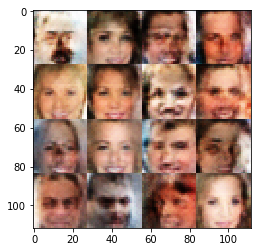

Step 2710 of Epoch 1/1... Discriminator Loss: 1.5284... Generator Loss: 0.5131
Step 2720 of Epoch 1/1... Discriminator Loss: 1.7184... Generator Loss: 0.4621
Step 2730 of Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.7787
Step 2740 of Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.5568
Step 2750 of Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 0.8131
Step 2760 of Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.6132
Step 2770 of Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 0.8146
Step 2780 of Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 1.3071
Step 2790 of Epoch 1/1... Discriminator Loss: 1.6494... Generator Loss: 0.4947
Step 2800 of Epoch 1/1... Discriminator Loss: 1.8122... Generator Loss: 0.3991


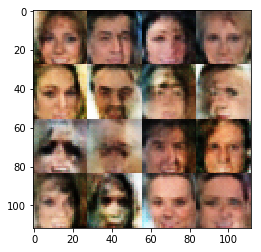

Step 2810 of Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 1.0977
Step 2820 of Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.8361
Step 2830 of Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.6605
Step 2840 of Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.6002
Step 2850 of Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.6750
Step 2860 of Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 1.0748
Step 2870 of Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.4671
Step 2880 of Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.7859
Step 2890 of Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.5237
Step 2900 of Epoch 1/1... Discriminator Loss: 1.5540... Generator Loss: 0.5035


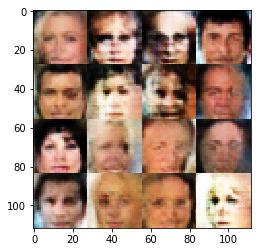

Step 2910 of Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.6161
Step 2920 of Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.8360
Step 2930 of Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.6861
Step 2940 of Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.6566
Step 2950 of Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.7685
Step 2960 of Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 0.6884
Step 2970 of Epoch 1/1... Discriminator Loss: 1.6466... Generator Loss: 0.4771
Step 2980 of Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.5683
Step 2990 of Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.6779
Step 3000 of Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.5216


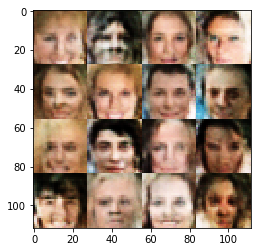

Step 3010 of Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 0.6798
Step 3020 of Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.5324
Step 3030 of Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 1.2748
Step 3040 of Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7808
Step 3050 of Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.7219
Step 3060 of Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.5343
Step 3070 of Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 0.4976
Step 3080 of Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.5925
Step 3090 of Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.7537
Step 3100 of Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 0.8668


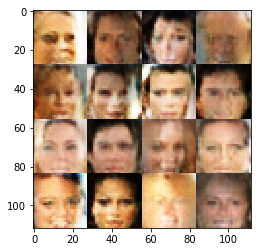

Step 3110 of Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.6526
Step 3120 of Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 0.8506
Step 3130 of Epoch 1/1... Discriminator Loss: 1.6731... Generator Loss: 0.4441
Step 3140 of Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.7554
Step 3150 of Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.5684
Step 3160 of Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.5790
Step 3170 of Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.5472
Step 3180 of Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.5708
Step 3190 of Epoch 1/1... Discriminator Loss: 1.6851... Generator Loss: 0.4623
Step 3200 of Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 0.8267


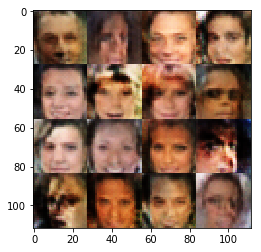

Step 3210 of Epoch 1/1... Discriminator Loss: 1.6720... Generator Loss: 0.6336
Step 3220 of Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.6731
Step 3230 of Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 0.9893
Step 3240 of Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.5631
Step 3250 of Epoch 1/1... Discriminator Loss: 0.8550... Generator Loss: 1.0943
Step 3260 of Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.7188
Step 3270 of Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.5422
Step 3280 of Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 0.8425
Step 3290 of Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 0.5146
Step 3300 of Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.9085


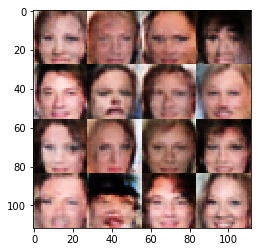

Step 3310 of Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.6997
Step 3320 of Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.6673
Step 3330 of Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.5346
Step 3340 of Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.7235
Step 3350 of Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.6396
Step 3360 of Epoch 1/1... Discriminator Loss: 0.8518... Generator Loss: 1.2076
Step 3370 of Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.8998
Step 3380 of Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 1.2613
Step 3390 of Epoch 1/1... Discriminator Loss: 1.6647... Generator Loss: 0.4322
Step 3400 of Epoch 1/1... Discriminator Loss: 0.6336... Generator Loss: 1.5247


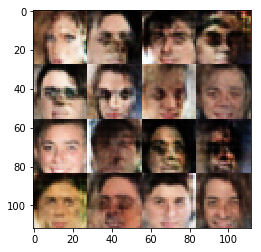

Step 3410 of Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.6061
Step 3420 of Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.6302
Step 3430 of Epoch 1/1... Discriminator Loss: 1.6613... Generator Loss: 0.4796
Step 3440 of Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 0.8714
Step 3450 of Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.8301
Step 3460 of Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.5762
Step 3470 of Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.6811
Step 3480 of Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.6962
Step 3490 of Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.5440
Step 3500 of Epoch 1/1... Discriminator Loss: 1.6312... Generator Loss: 0.5066


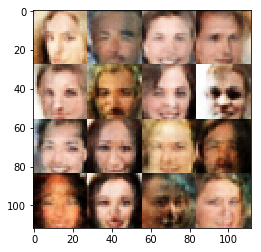

Step 3510 of Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.7011
Step 3520 of Epoch 1/1... Discriminator Loss: 1.6089... Generator Loss: 0.4878
Step 3530 of Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.7961
Step 3540 of Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.5332
Step 3550 of Epoch 1/1... Discriminator Loss: 1.7010... Generator Loss: 0.4554
Step 3560 of Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.6886
Step 3570 of Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.7713
Step 3580 of Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 0.9105
Step 3590 of Epoch 1/1... Discriminator Loss: 1.8272... Generator Loss: 0.4091
Step 3600 of Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.5624


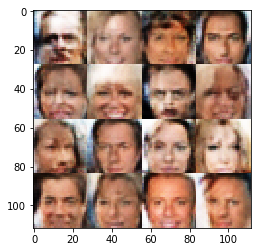

Step 3610 of Epoch 1/1... Discriminator Loss: 1.5279... Generator Loss: 0.5492
Step 3620 of Epoch 1/1... Discriminator Loss: 1.5556... Generator Loss: 0.4983
Step 3630 of Epoch 1/1... Discriminator Loss: 1.8565... Generator Loss: 0.3976
Step 3640 of Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.6796
Step 3650 of Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.7911
Step 3660 of Epoch 1/1... Discriminator Loss: 0.8480... Generator Loss: 1.2698
Step 3670 of Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 1.1892
Step 3680 of Epoch 1/1... Discriminator Loss: 1.7505... Generator Loss: 0.4579
Step 3690 of Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 1.2709
Step 3700 of Epoch 1/1... Discriminator Loss: 1.6363... Generator Loss: 0.4594


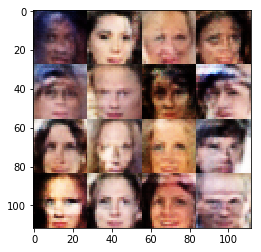

Step 3710 of Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 0.8925
Step 3720 of Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.6937
Step 3730 of Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 1.2531
Step 3740 of Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.5273
Step 3750 of Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.5970
Step 3760 of Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 0.8540
Step 3770 of Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 1.0104
Step 3780 of Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 1.3113
Step 3790 of Epoch 1/1... Discriminator Loss: 0.5600... Generator Loss: 1.6558
Step 3800 of Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.5715


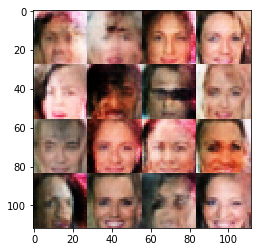

Step 3810 of Epoch 1/1... Discriminator Loss: 1.5626... Generator Loss: 0.5529
Step 3820 of Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.6751
Step 3830 of Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 1.6646
Step 3840 of Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 0.5869
Step 3850 of Epoch 1/1... Discriminator Loss: 2.0616... Generator Loss: 0.3950
Step 3860 of Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 1.1383
Step 3870 of Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.6293
Step 3880 of Epoch 1/1... Discriminator Loss: 1.7674... Generator Loss: 0.4509
Step 3890 of Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.7697
Step 3900 of Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.8919


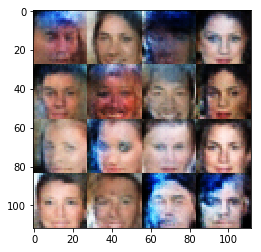

Step 3910 of Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.6543
Step 3920 of Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.6285
Step 3930 of Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.6449
Step 3940 of Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.5658
Step 3950 of Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.6781
Step 3960 of Epoch 1/1... Discriminator Loss: 1.5959... Generator Loss: 0.5049
Step 3970 of Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 0.9507
Step 3980 of Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 0.7210
Step 3990 of Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6769
Step 4000 of Epoch 1/1... Discriminator Loss: 1.5927... Generator Loss: 0.4458


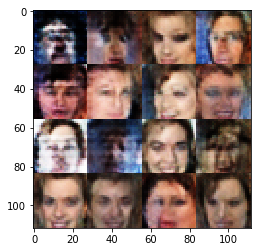

Step 4010 of Epoch 1/1... Discriminator Loss: 1.5613... Generator Loss: 0.4783
Step 4020 of Epoch 1/1... Discriminator Loss: 1.6023... Generator Loss: 0.4880
Step 4030 of Epoch 1/1... Discriminator Loss: 1.5449... Generator Loss: 0.5555
Step 4040 of Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 1.0593
Step 4050 of Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.8106
Step 4060 of Epoch 1/1... Discriminator Loss: 1.6639... Generator Loss: 0.4371
Step 4070 of Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.7001
Step 4080 of Epoch 1/1... Discriminator Loss: 1.6361... Generator Loss: 0.6430
Step 4090 of Epoch 1/1... Discriminator Loss: 1.9749... Generator Loss: 0.4323
Step 4100 of Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.5619


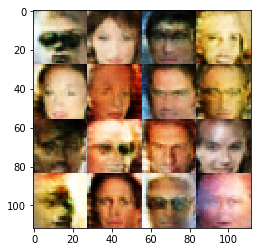

Step 4110 of Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.6233
Step 4120 of Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.6328
Step 4130 of Epoch 1/1... Discriminator Loss: 1.8726... Generator Loss: 0.4059
Step 4140 of Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.6133
Step 4150 of Epoch 1/1... Discriminator Loss: 1.7482... Generator Loss: 0.4553
Step 4160 of Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.7579
Step 4170 of Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.6490
Step 4180 of Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.6724
Step 4190 of Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.8749
Step 4200 of Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.6407


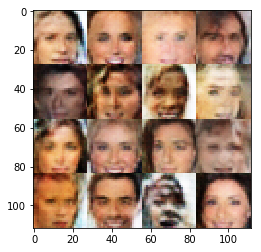

Step 4210 of Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.7159
Step 4220 of Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.6783
Step 4230 of Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.9211
Step 4240 of Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 0.7685
Step 4250 of Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.6042
Step 4260 of Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.6642
Step 4270 of Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.8015
Step 4280 of Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 0.6556
Step 4290 of Epoch 1/1... Discriminator Loss: 1.6461... Generator Loss: 0.4735
Step 4300 of Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.6917


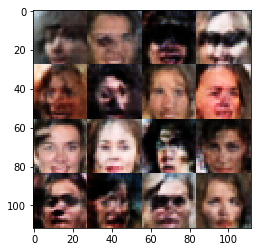

Step 4310 of Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 0.9343
Step 4320 of Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.7657
Step 4330 of Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 0.8599
Step 4340 of Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.6249
Step 4350 of Epoch 1/1... Discriminator Loss: 1.8317... Generator Loss: 0.4655
Step 4360 of Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.4890
Step 4370 of Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.5819
Step 4380 of Epoch 1/1... Discriminator Loss: 1.5724... Generator Loss: 0.5789
Step 4390 of Epoch 1/1... Discriminator Loss: 1.5874... Generator Loss: 0.4861
Step 4400 of Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.7535


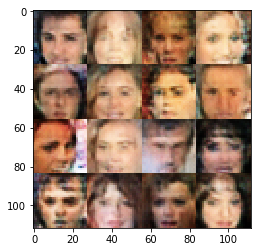

Step 4410 of Epoch 1/1... Discriminator Loss: 1.8115... Generator Loss: 0.4429
Step 4420 of Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.6779
Step 4430 of Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 0.7989
Step 4440 of Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.5958
Step 4450 of Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 0.5169
Step 4460 of Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 1.2151
Step 4470 of Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.7678
Step 4480 of Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.5641
Step 4490 of Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.5292
Step 4500 of Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.6559


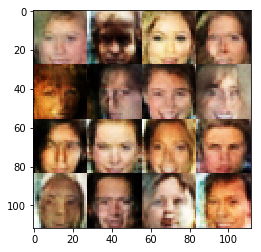

Step 4510 of Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.5977
Step 4520 of Epoch 1/1... Discriminator Loss: 1.8003... Generator Loss: 0.4586
Step 4530 of Epoch 1/1... Discriminator Loss: 1.7609... Generator Loss: 0.5454
Step 4540 of Epoch 1/1... Discriminator Loss: 1.7057... Generator Loss: 0.4290
Step 4550 of Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.5269
Step 4560 of Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 0.7992
Step 4570 of Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.5259
Step 4580 of Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 0.8955
Step 4590 of Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.6713
Step 4600 of Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 0.9164


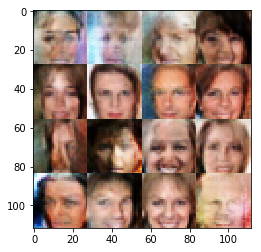

Step 4610 of Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.6597
Step 4620 of Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.5989
Step 4630 of Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.6282
Step 4640 of Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.7254
Step 4650 of Epoch 1/1... Discriminator Loss: 1.7336... Generator Loss: 0.4651
Step 4660 of Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.6983
Step 4670 of Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 0.7746
Step 4680 of Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.7093
Step 4690 of Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.5743
Step 4700 of Epoch 1/1... Discriminator Loss: 1.7074... Generator Loss: 0.4586


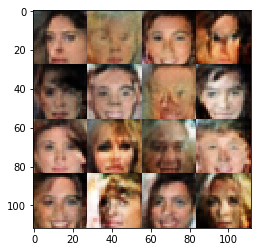

Step 4710 of Epoch 1/1... Discriminator Loss: 1.7687... Generator Loss: 0.4576
Step 4720 of Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 0.9678
Step 4730 of Epoch 1/1... Discriminator Loss: 1.5888... Generator Loss: 0.4619
Step 4740 of Epoch 1/1... Discriminator Loss: 1.5449... Generator Loss: 0.5375
Step 4750 of Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 1.0132
Step 4760 of Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.7674
Step 4770 of Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.6828
Step 4780 of Epoch 1/1... Discriminator Loss: 1.7857... Generator Loss: 0.4227
Step 4790 of Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.5822
Step 4800 of Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.5970


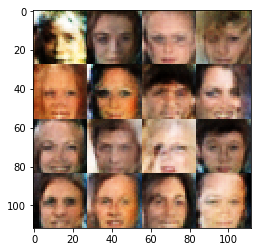

Step 4810 of Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.5588
Step 4820 of Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.5945
Step 4830 of Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.8755
Step 4840 of Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.6230
Step 4850 of Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 0.9409
Step 4860 of Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 0.8323
Step 4870 of Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.8950
Step 4880 of Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.7045
Step 4890 of Epoch 1/1... Discriminator Loss: 2.3262... Generator Loss: 0.3604
Step 4900 of Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.6719


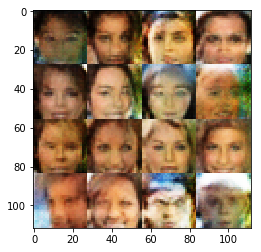

Step 4910 of Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.6173
Step 4920 of Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.6487
Step 4930 of Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.6869
Step 4940 of Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.6247
Step 4950 of Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 0.8666
Step 4960 of Epoch 1/1... Discriminator Loss: 1.5394... Generator Loss: 0.5020
Step 4970 of Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 0.8940
Step 4980 of Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.7321
Step 4990 of Epoch 1/1... Discriminator Loss: 1.5684... Generator Loss: 0.5406
Step 5000 of Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.8135


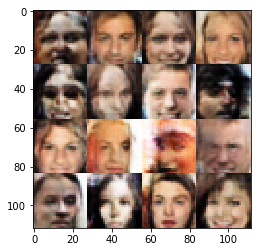

Step 5010 of Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.4976
Step 5020 of Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 0.8815
Step 5030 of Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.7282
Step 5040 of Epoch 1/1... Discriminator Loss: 0.8439... Generator Loss: 1.1533
Step 5050 of Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.7140
Step 5060 of Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.6929
Step 5070 of Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 0.9641
Step 5080 of Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.6933
Step 5090 of Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 0.7545
Step 5100 of Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.5681


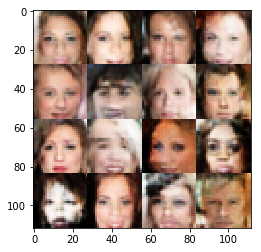

Step 5110 of Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.5279
Step 5120 of Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.6991
Step 5130 of Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.6309
Step 5140 of Epoch 1/1... Discriminator Loss: 1.7482... Generator Loss: 0.4369
Step 5150 of Epoch 1/1... Discriminator Loss: 1.8572... Generator Loss: 0.3998
Step 5160 of Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.5379
Step 5170 of Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.5974
Step 5180 of Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.7157
Step 5190 of Epoch 1/1... Discriminator Loss: 1.5777... Generator Loss: 0.4977


IndexError: list index out of range

In [83]:
batch_size = 16
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.